## Preparing the ANN input

In [15]:
import uproot
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

* Dataframe definition:

In [16]:
class ND280_dataset:
    def __init__(self, path):
        #tree_hattracks = uproot.open(path)['hatdigits']
        tree_hattracks = uproot.open(path)['hatdigits']
        
        df = tree_hattracks.arrays()
        tree = ak.to_dataframe(df)
        keys = tree.index.get_level_values('entry').unique()
        
        self.tree = tree
        self.keys = keys
        
    def __getitem__(self, i):
        key = self.keys[i]
        return self.tree.loc[key]
    
    def __len__(self):
        return len(self.keys)

**Step 1**  
Define path_1 and path_2 dataframes and assign 'npart' column with the information of the number of particles involved.

- path_1 (corresponds to events with a single particle involved):

In [17]:
path_1="/data/neutrinos/common/casado/T2K/HAT-Reco/treemaker_mu_minus_800.root"

In [18]:
ds = ND280_dataset(path_1)

In [19]:
df = pd.DataFrame(ds.tree)

In [20]:
df_unique_entries = df.groupby('entry').first()

In [21]:
df.groupby('entry').first()

,event,hat,plate,fem,fec,asic,channel,time,nsamples,adc,row,col,y,z,qmax,tmax,fwhm
entry,,,,,,,,,,,,,,,,,
0,0,0,0,2,1,3,9,144,52,246,4,24,849.315002,-1660.115967,292,154,24
1,0,0,0,2,1,3,10,91,68,246,4,25,849.315002,-1648.835938,650,113,22
2,0,0,0,2,1,3,11,86,49,257,4,26,849.315002,-1637.555908,1899,105,14
3,0,0,0,2,1,3,20,134,66,281,5,25,859.505005,-1648.835938,304,158,30
4,0,0,0,2,1,3,21,101,119,253,5,26,859.505005,-1637.555908,311,141,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087925,9999,0,0,7,0,0,64,73,48,227,30,4,773.255005,-1464.715942,820,91,14
2087926,9999,0,0,7,0,0,65,74,61,260,30,3,773.255005,-1475.995972,415,91,18
2087927,9999,0,0,7,0,0,72,79,52,247,31,6,783.445007,-1442.156006,357,97,23


In [22]:
print(len(df.groupby('event').first())-1)

9999


In [23]:
result_array = []
len_array = []
event_array = []

for event_value in range(9999):
    df_sel = df_unique_entries[df_unique_entries['event'] == event_value]
    
    data_list = []  
    
    for fem_value in range(8):
        df_sel_fem = df_sel[df_sel['fem'] == fem_value]
        num_inputs = len(df_sel_fem)

        if num_inputs != 0:
            mask_qmax = df_sel_fem['qmax'] != 0
            mask_tmax = df_sel_fem['tmax'] != 0

            qmax_values = df_sel_fem['qmax'][mask_qmax]
            tmax_values = df_sel_fem['tmax'][mask_tmax]
            
            # Apply row and col transformations based on fem_value
            row_offset = 0
            col_offset = 0
            if fem_value == 0:
                row_offset += 32
                col_offset += 0
            elif fem_value == 1:
                row_offset += 32
                col_offset += 36
            elif fem_value == 2:
                row_offset += 32
                col_offset += 72
            elif fem_value == 3:
                row_offset += 32
                col_offset += 108
            elif fem_value == 5:
                col_offset += 36
            elif fem_value == 6:
                col_offset += 72
            elif fem_value == 7:
                col_offset += 108

            row_values = df_sel_fem['row'][mask_qmax] + row_offset
            col_values = df_sel_fem['col'][mask_qmax] + col_offset
            
            for qmax, tmax, row, col in zip(qmax_values, tmax_values, row_values, col_values):
                data_list.append([row, col, qmax, tmax])
            
    result_array.append(data_list)
    len_array.append(len(data_list))
    event_array.append(event_value)

df_result_1 = pd.DataFrame({
    'event': event_array,
    'nhits': len_array,
    '[row, col, qmax, tmax]': result_array})

df_result_1

,event,nhits,"[row, col, qmax, tmax]"
0,0,223,"[[36, 96, 292, 154], [36, 97, 650, 113], [36, ..."
1,1,207,"[[36, 116, 293, 64], [32, 113, 671, 48], [32, ..."
2,2,217,"[[34, 88, 300, 81], [34, 89, 450, 56], [33, 88..."
3,3,207,"[[32, 98, 328, 59], [41, 106, 287, 100], [41, ..."
4,4,215,"[[36, 116, 477, 64], [37, 116, 297, 80], [32, ..."
...,...,...,...
9994,9994,223,"[[36, 70, 287, 136], [36, 71, 526, 90], [35, 6..."
9995,9995,210,"[[38, 89, 298, 125], [37, 88, 291, 123], [37, ..."
9996,9996,197,"[[40, 133, 373, 97], [40, 134, 714, 91], [41, ..."
9997,9997,223,"[[36, 98, 300, 113], [32, 95, 628, 90], [32, 9..."


In [24]:
df_result_1['npart'] = 1

In [25]:
df_result_1

,event,nhits,"[row, col, qmax, tmax]",npart
0,0,223,"[[36, 96, 292, 154], [36, 97, 650, 113], [36, ...",1
1,1,207,"[[36, 116, 293, 64], [32, 113, 671, 48], [32, ...",1
2,2,217,"[[34, 88, 300, 81], [34, 89, 450, 56], [33, 88...",1
3,3,207,"[[32, 98, 328, 59], [41, 106, 287, 100], [41, ...",1
4,4,215,"[[36, 116, 477, 64], [37, 116, 297, 80], [32, ...",1
...,...,...,...,...
9994,9994,223,"[[36, 70, 287, 136], [36, 71, 526, 90], [35, 6...",1
9995,9995,210,"[[38, 89, 298, 125], [37, 88, 291, 123], [37, ...",1
9996,9996,197,"[[40, 133, 373, 97], [40, 134, 714, 91], [41, ...",1
9997,9997,223,"[[36, 98, 300, 113], [32, 95, 628, 90], [32, 9...",1


In [26]:
qmax_list=[]
tmax_list=[]
for i in range(len(df_result_1)):
    for array in df_result_1.at[i, '[row, col, qmax, tmax]']:
        row, col, qmax, tmax = array
        qmax_list.append(qmax)
        tmax_list.append(tmax)

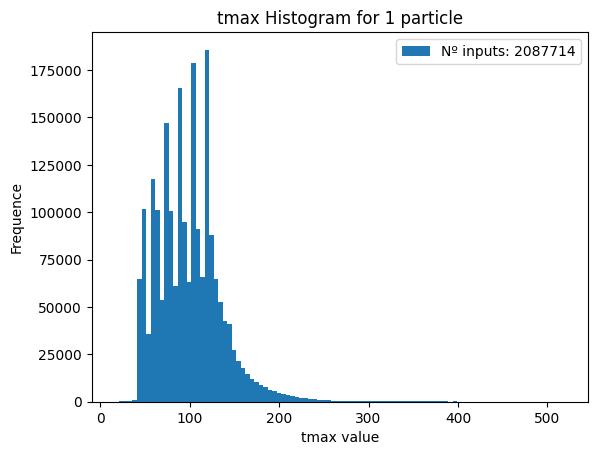

In [27]:
num_inputs= len(tmax_list)

plt.hist(tmax_list, bins=100) 

plt.xlabel('tmax value')
plt.ylabel('Frequence')
plt.title('tmax Histogram for 1 particle')
legend_label= f'Nº inputs: {num_inputs}'
plt.legend([legend_label])

plt.show()

- path_2 (corresponds to events with two particles involved):

In [28]:
path_2= "/data/neutrinos/common/casado/T2K/HAT-Reco/treemaker_two_muons_29Aug2023.root"

In [29]:
ds = ND280_dataset(path_2)

In [30]:
df = pd.DataFrame(ds.tree)

In [31]:
df_unique_entries = df.groupby('entry').first()

In [32]:
print(len(df.groupby('event').first())-1)

9999


In [33]:
result_array = []
len_array = []
event_array = []

for event_value in range(9999):
    df_sel = df_unique_entries[df_unique_entries['event'] == event_value]
    
    data_list = []  
    
    for fem_value in range(8):
        df_sel_fem = df_sel[df_sel['fem'] == fem_value]
        num_inputs = len(df_sel_fem)

        if num_inputs != 0:
            mask_qmax = df_sel_fem['qmax'] != 0
            mask_tmax = df_sel_fem['tmax'] != 0

            qmax_values = df_sel_fem['qmax'][mask_qmax]
            tmax_values = df_sel_fem['tmax'][mask_tmax]
            
            # Apply row and col transformations based on fem_value
            row_offset = 0
            col_offset = 0
            if fem_value == 0:
                row_offset += 32
                col_offset += 0
            elif fem_value == 1:
                row_offset += 32
                col_offset += 36
            elif fem_value == 2:
                row_offset += 32
                col_offset += 72
            elif fem_value == 3:
                row_offset += 32
                col_offset += 108
            elif fem_value == 5:
                col_offset += 36
            elif fem_value == 6:
                col_offset += 72
            elif fem_value == 7:
                col_offset += 108

            row_values = df_sel_fem['row'][mask_qmax] + row_offset
            col_values = df_sel_fem['col'][mask_qmax] + col_offset
            
            for qmax, tmax, row, col in zip(qmax_values, tmax_values, row_values, col_values):
                data_list.append([row, col, qmax, tmax])
            
    result_array.append(data_list)
    len_array.append(len(data_list))
    event_array.append(event_value)

df_result_2 = pd.DataFrame({
    'event': event_array,
    'nhits': len_array,
    '[row, col, qmax, tmax]': result_array})

df_result_2

,event,nhits,"[row, col, qmax, tmax]"
0,0,297,"[[48, 71, 310, 293], [47, 71, 352, 294], [46, ..."
1,1,397,"[[59, 31, 333, 326], [59, 30, 585, 321], [59, ..."
2,2,370,"[[59, 69, 654, 355], [59, 68, 372, 356], [58, ..."
3,3,421,"[[59, 57, 319, 290], [59, 58, 527, 287], [58, ..."
4,4,347,"[[56, 35, 367, 373], [57, 35, 352, 369], [58, ..."
...,...,...,...
9994,9994,379,"[[51, 53, 472, 376], [50, 53, 673, 375], [49, ..."
9995,9995,381,"[[56, 68, 370, 296], [56, 69, 478, 292], [57, ..."
9996,9996,387,"[[59, 70, 495, 344], [59, 69, 425, 346], [58, ..."
9997,9997,380,"[[56, 32, 400, 360], [56, 33, 842, 356], [56, ..."


In [34]:
df_result_2['npart'] = 2

In [35]:
df_result_2

,event,nhits,"[row, col, qmax, tmax]",npart
0,0,297,"[[48, 71, 310, 293], [47, 71, 352, 294], [46, ...",2
1,1,397,"[[59, 31, 333, 326], [59, 30, 585, 321], [59, ...",2
2,2,370,"[[59, 69, 654, 355], [59, 68, 372, 356], [58, ...",2
3,3,421,"[[59, 57, 319, 290], [59, 58, 527, 287], [58, ...",2
4,4,347,"[[56, 35, 367, 373], [57, 35, 352, 369], [58, ...",2
...,...,...,...,...
9994,9994,379,"[[51, 53, 472, 376], [50, 53, 673, 375], [49, ...",2
9995,9995,381,"[[56, 68, 370, 296], [56, 69, 478, 292], [57, ...",2
9996,9996,387,"[[59, 70, 495, 344], [59, 69, 425, 346], [58, ...",2
9997,9997,380,"[[56, 32, 400, 360], [56, 33, 842, 356], [56, ...",2


In [36]:
qmax_list_2=[]
tmax_list_2=[]
for i in range(len(df_result_2)):
    for array in df_result_2.at[i, '[row, col, qmax, tmax]']:
        row, col, qmax, tmax = array
        qmax_list_2.append(qmax)
        tmax_list_2.append(tmax)

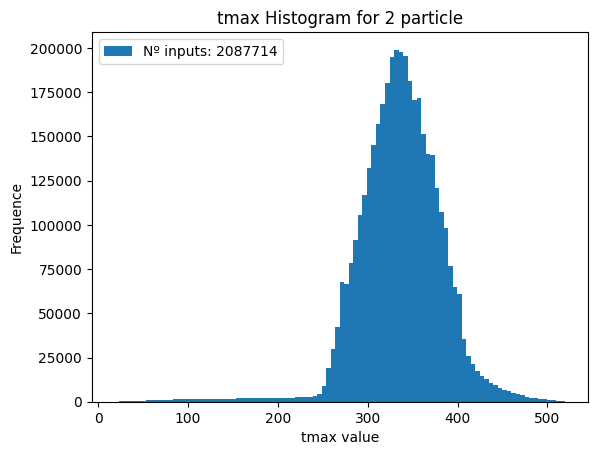

In [46]:
num_inputs= len(tmax_list)

plt.hist(tmax_list_2, bins=100) 

plt.xlabel('tmax value')
plt.ylabel('Frequence')
plt.title('tmax Histogram for 2 particle')
legend_label= f'Nº inputs: {num_inputs}'
plt.legend([legend_label])

plt.show()

**Step 2**  
Merge both dataframes into one

In [38]:
df_both_paths=pd.concat([df_result_1, df_result_2])

In [39]:
df_both_paths.reset_index(drop=True, inplace=True)

In [40]:
df_both_paths

,event,nhits,"[row, col, qmax, tmax]",npart
0,0,223,"[[36, 96, 292, 154], [36, 97, 650, 113], [36, ...",1
1,1,207,"[[36, 116, 293, 64], [32, 113, 671, 48], [32, ...",1
2,2,217,"[[34, 88, 300, 81], [34, 89, 450, 56], [33, 88...",1
3,3,207,"[[32, 98, 328, 59], [41, 106, 287, 100], [41, ...",1
4,4,215,"[[36, 116, 477, 64], [37, 116, 297, 80], [32, ...",1
...,...,...,...,...
19993,9994,379,"[[51, 53, 472, 376], [50, 53, 673, 375], [49, ...",2
19994,9995,381,"[[56, 68, 370, 296], [56, 69, 478, 292], [57, ...",2
19995,9996,387,"[[59, 70, 495, 344], [59, 69, 425, 346], [58, ...",2
19996,9997,380,"[[56, 32, 400, 360], [56, 33, 842, 356], [56, ...",2


**Step 3**   
Randomize the inputs entries

In [41]:
input_paths=df_both_paths.sample(frac=1)

In [42]:
input_paths.reset_index(drop=True, inplace=True)

In [43]:
input_paths

,event,nhits,"[row, col, qmax, tmax]",npart
0,4751,231,"[[36, 59, 295, 160], [36, 60, 425, 121], [36, ...",1
1,6069,420,"[[57, 62, 286, 434], [59, 66, 364, 327], [59, ...",2
2,1891,411,"[[56, 26, 298, 397], [56, 25, 663, 383], [56, ...",2
3,5583,370,"[[57, 44, 288, 459], [48, 44, 359, 347], [49, ...",2
4,1556,220,"[[40, 62, 313, 93], [36, 58, 303, 111], [36, 5...",1
...,...,...,...,...
19993,5407,370,"[[56, 45, 308, 333], [56, 46, 657, 305], [56, ...",2
19994,8250,374,"[[56, 34, 352, 303], [56, 35, 1184, 297], [57,...",2
19995,4071,394,"[[56, 43, 386, 350], [56, 42, 407, 349], [57, ...",2
19996,9931,175,"[[40, 133, 294, 154], [40, 134, 445, 105], [36...",1


Save Dataframe:

In [44]:
path_pwd='/data/neutrinos/common/mrodrigu/CNN_discriminate_1-2_particles/ANN/input.csv'

In [45]:
input_paths.to_csv(path_pwd, index=False)